In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline  

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

Using TensorFlow backend.


# Text data

https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

In [2]:
# Read in only the two columns we need 
reviews = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv',
                     usecols = ['Review Text', 'Recommended IND'])
print(reviews.head())

                                         Review Text  Recommended IND
0  Absolutely wonderful - silky and sexy and comf...                1
1  Love this dress!  it's sooo pretty.  i happene...                1
2  I had such high hopes for this dress and reall...                0
3  I love, love, love this jumpsuit. it's fun, fl...                1
4  This shirt is very flattering to all due to th...                1


## Plot frequencies

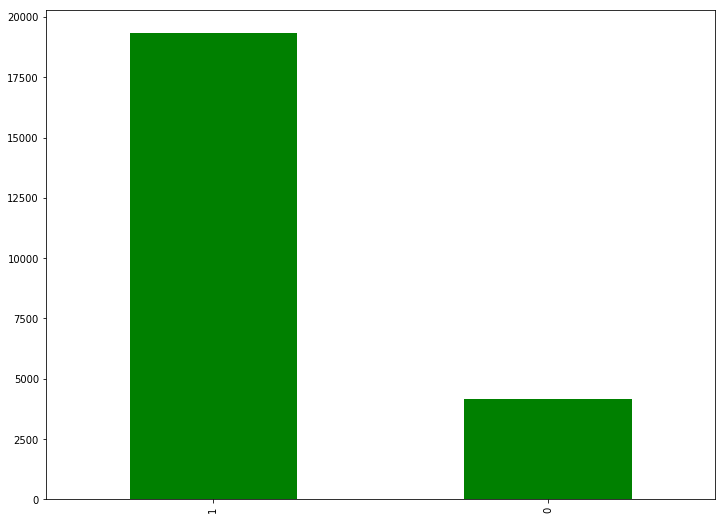

In [3]:
f, g = plt.subplots(figsize=(12, 9))
reviews['Recommended IND'].value_counts().head(10).plot.bar(color="green")

In [4]:
# just text
text = reviews['Review Text']

n_reviews = len(text)
n_chars = len(' '.join(map(str, text)))

print("We have %d reviews" % n_reviews)
print("The reviews add up to %d characters" % n_chars)

We have 23486 reviews
The reviews add up to 7015023 characters


In [5]:
# let's reduce the size to make training faster
# take the first 20% of reviews
sample_size = int(len(text) * 0.2)

text = text[:sample_size].values
text = text.tolist()
text[:10]

['Absolutely wonderful - silky and sexy and comfortable',
 'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
 'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
 "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments

In [6]:
len(text)

4697

In [7]:
text_to_word_sequence?

Signature:
text_to_word_sequence(
    text,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
)
Docstring:
Converts a text to a sequence of words (or tokens).

# Arguments
    text: Input text (string).
    filters: list (or concatenation) of characters to filter out, such as
        punctuation. Default: ``!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n``,
        includes basic punctuation, tabs, and newlines.
    lower: boolean. Whether to convert the input to lowercase.
    split: str. Separator for word splitting.

# Returns
    A list of words (or tokens).
File:      /usr/local/lib/python3.6/site-packages/keras_preprocessing/text.py
Type:      function


In [8]:
# clean document

words = list()

for i in range(len(text)):
        tokens = text_to_word_sequence(str(text[i]))
        #print(tokens)
        words.append(tokens)

print(words[:3])

[['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable'], ['love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a', 'store', 'and', "i'm", 'glad', 'i', 'did', 'bc', 'i', 'never', 'would', 'have', 'ordered', 'it', 'online', 'bc', "it's", 'petite', 'i', 'bought', 'a', 'petite', 'and', 'am', "5'8", 'i', 'love', 'the', 'length', 'on', 'me', 'hits', 'just', 'a', 'little', 'below', 'the', 'knee', 'would', 'definitely', 'be', 'a', 'true', 'midi', 'on', 'someone', 'who', 'is', 'truly', 'petite'], ['i', 'had', 'such', 'high', 'hopes', 'for', 'this', 'dress', 'and', 'really', 'wanted', 'it', 'to', 'work', 'for', 'me', 'i', 'initially', 'ordered', 'the', 'petite', 'small', 'my', 'usual', 'size', 'but', 'i', 'found', 'this', 'to', 'be', 'outrageously', 'small', 'so', 'small', 'in', 'fact', 'that', 'i', 'could', 'not', 'zip', 'it', 'up', 'i', 'reordered', 'it', 'in', 'petite', 'medium', 'which', 'was', 'just', 'ok', 'overall', 'the', 'top'

In [9]:
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(words)

In [10]:
# summarize what was learned
#print(t.word_counts)
print(t.document_count)
#print(t.word_index)
#print(t.word_docs)

4697


In [11]:
# integer encode documents
encoded_docs = t.texts_to_matrix(words, mode='count')
print(len(encoded_docs))
print(encoded_docs)

4697
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  2.  5. ...  0.  0.  0.]
 [ 0.  5.  5. ...  0.  0.  0.]
 ...
 [ 0.  5.  4. ...  1.  1.  0.]
 [ 0.  2.  2. ...  0.  0.  0.]
 [ 0. 10.  2. ...  0.  0.  1.]]


In [12]:
response = reviews['Recommended IND']
y_train = response[:sample_size].values
print(len(y_train))
print(y_train[:10])

4697
[1 1 0 1 1 0 1 1 1 1]


In [13]:
x_train = sequence.pad_sequences(encoded_docs)
print('x_train shape:', x_train.shape)

x_train shape: (4697, 7333)


In [14]:
# set parameters:
max_features = 5000
maxlen = 7333
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

In [15]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 7333, 50)          250000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7333, 50)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7331, 250)         37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
__________

In [17]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.3)

Train on 3287 samples, validate on 1410 samples
Epoch 1/2
3287/3287 [==============================] - 190s 58ms/step - loss: 0.4874 - acc: 0.8169 - val_loss: 0.4885 - val_acc: 0.8284
Epoch 2/2
3287/3287 [==============================] - 188s 57ms/step - loss: 0.4763 - acc: 0.8181 - val_loss: 0.4819 - val_acc: 0.8284


In [19]:
from keras.models import Model
layer_name = 'embedding_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

In [20]:
intermediate_output = intermediate_layer_model.predict(x_train[0:100])

In [22]:
intermediate_output.shape

(100, 7333, 50)

In [ ]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())

In [ ]:
first_layer_weights = model.layers[0].get_weights()[0]
first_layer_biases  = model.layers[0].get_weights()[1]
second_layer_weights = model.layers[1].get_weights()[0]
second_layer_biases  = model.layers[1].get_weights()[1]

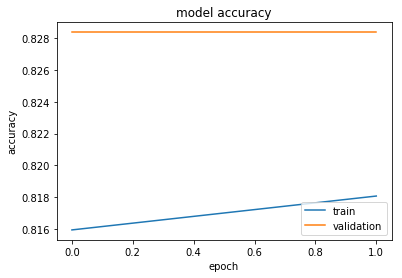

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'lower right')
plt.show()

In [27]:
model.predict(x_train[[0]])

array([[0.78638685]], dtype=float32)

In [28]:
model.evaluate(x_train[[0]], y_train[[0]])

1/1 [==============================] - 0s 25ms/step


[0.24030643701553345, 1.0]